In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

/Users/varunrajan/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/varunrajan/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Initial Data Exploration

## Load

In [6]:
csv_file = 'df_yelp_cleaned_up.csv'
df_manhattan = pd.read_csv(csv_file)

In [8]:
def plot_locations(df, xname='longitude', yname='latitude',
                   # xlim=(-74.04, -73.9), ylim=(40.67, 40.89),
                   figsize=(12, 7)):
    idxgood = df[xname].notnull() & df[yname].notnull()
    df_plot = df[idxgood]
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.scatter(df_plot[xname], df_plot[yname])
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    plt.show()

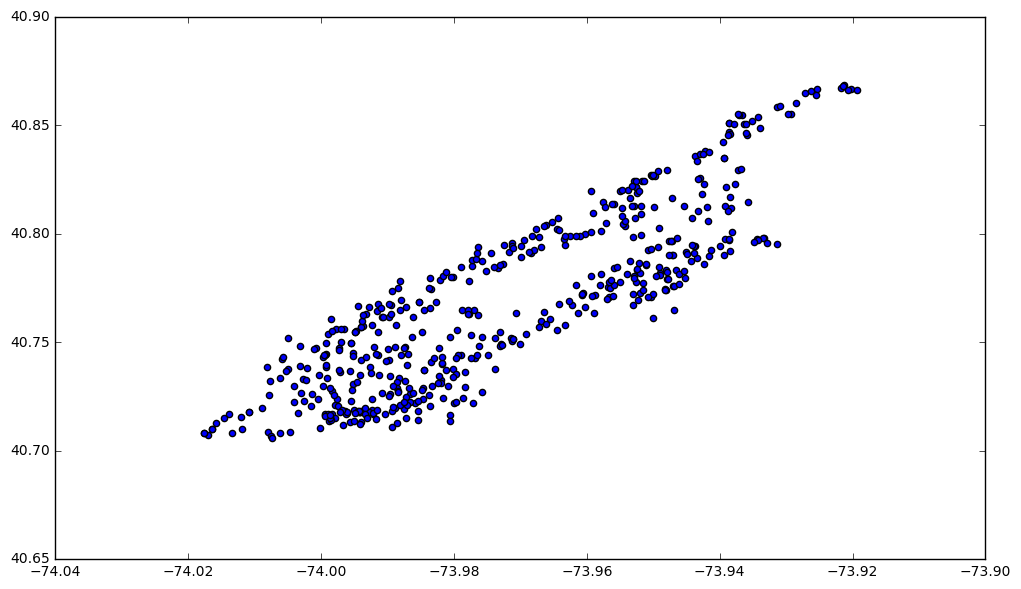

In [9]:
plot_locations(df_manhattan)

In [10]:
df_zip = pd.read_csv('manhattan_zip_codes.tsv', sep='\t')

In [11]:
df_pop = pd.read_csv('census_pop.csv')
df_pop.columns = ['Zip Code', 'Population']

In [12]:
def merge_all_df(df_zip, df_stores, df_pop):
    df_stores_grouped = df_stores.groupby(by=['Zip Code']).size().reset_index(name='Store Count')
    df_all = df_zip.merge(df_stores_grouped, how='left', on='Zip Code')
    df_all = df_all.merge(df_pop, how='left', on='Zip Code')
    df_all['Store Count'].fillna(0, inplace=True)
    idx_pop_bad = df_all['Population'].isnull() | (df_all['Population'] == 0.0)
    df_all.loc[idx_pop_bad, 'Population'] = 1
    return df_all

In [13]:
df_all = merge_all_df(df_zip, df_manhattan, df_pop)

In [14]:
df_all

,Neighborhood,Zip Code,Store Count,Population
0,West Midtown,10001,17.0,21102.0
1,Lower East Side,10002,37.0,81410.0
2,Greenwich Village,10003,25.0,56024.0
3,Financial District,10004,0.0,3089.0
4,Financial District,10005,1.0,7135.0
5,Financial District,10006,2.0,3011.0
6,Financial District,10007,1.0,6988.0
7,East Greenwich Village,10009,17.0,61347.0
8,Gramercy,10010,15.0,31834.0
9,Chelsea Greenwich Village,10011,17.0,50984.0


# PyMC

In [16]:
# y ~ NBD(mu=u*exp(Xi*B), overdispersion=omega)

In [15]:
import pymc3 as pm

In [17]:
df_try = df_all[df_all['Population'] > 100]

In [18]:
df_try['Pop'] = df_try['Population']/1000

In [23]:
df_try

,Neighborhood,Zip Code,Store Count,Population,Pop
0,West Midtown,10001,17.0,21102.0,21.102
1,Lower East Side,10002,37.0,81410.0,81.410
2,Greenwich Village,10003,25.0,56024.0,56.024
3,Financial District,10004,0.0,3089.0,3.089
4,Financial District,10005,1.0,7135.0,7.135
5,Financial District,10006,2.0,3011.0,3.011
6,Financial District,10007,1.0,6988.0,6.988
7,East Greenwich Village,10009,17.0,61347.0,61.347
8,Gramercy,10010,15.0,31834.0,31.834
9,Chelsea Greenwich Village,10011,17.0,50984.0,50.984


## Poisson

In [25]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    intercept = pm.Normal('intercept', mu=0., sd=10.)
    sigma = pm.HalfNormal('sigma', sd=10.)
    alpha_zip = pm.Normal('alpha_zip', mu=0., sd=sigma, shape=df_try.shape[0])
    
    # define linear model and exp link function
    theta = intercept + alpha_zip
    mu = np.array(df_try['Pop'])*np.exp(theta)

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=mu, observed=df_try['Store Count'])

In [34]:
with model:
    res = pm.variational.advi()
    trace = pm.sample(20000, start=res.means, njobs=2, step=pm.NUTS())

Average ELBO = -313.54: 100%|██████████| 5000/5000 [00:00<00:00, 11876.23it/s]
Finished [100%]: Average ELBO = -281.35
100%|██████████| 20000/20000 [05:03<00:00, 65.81it/s]


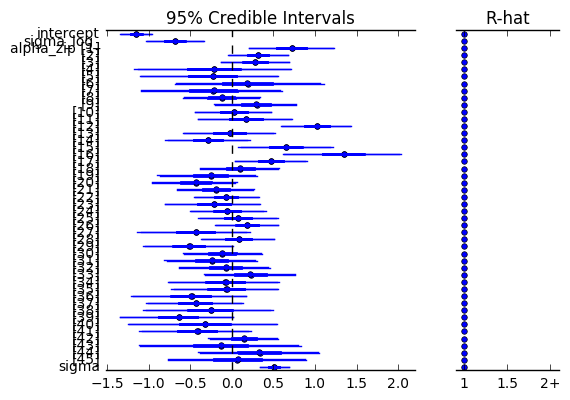

In [35]:
pm.forestplot(trace)

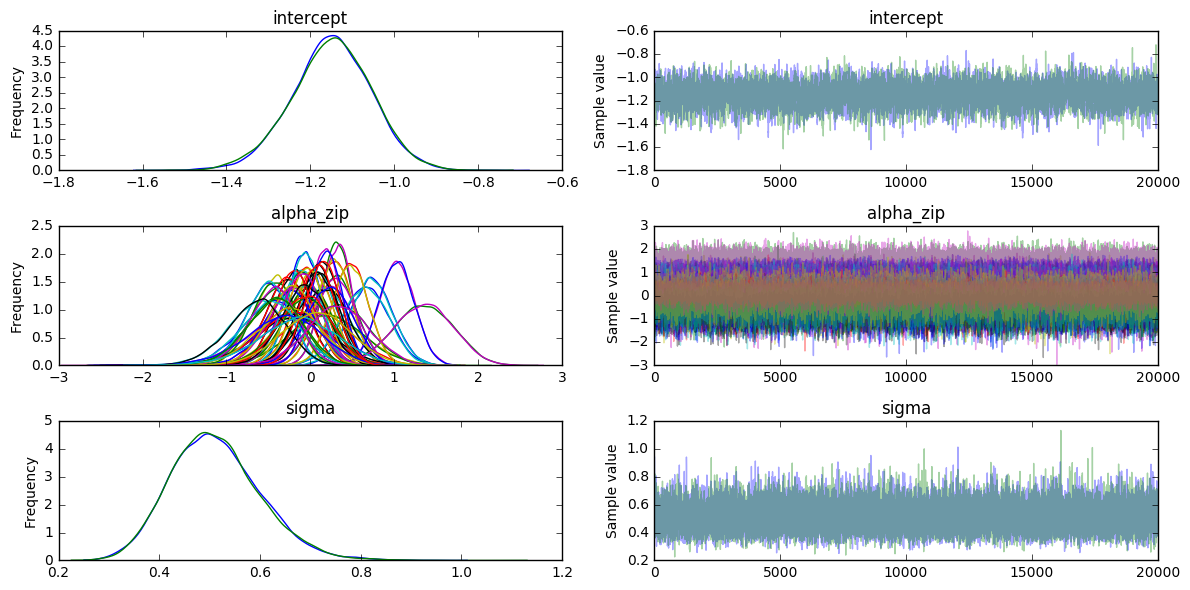

In [36]:
pm.traceplot(trace)
plt.show()

In [35]:
with pm.Model() as model_2:

    # define priors, weakly informative Normal
    intercept = pm.Normal('intercept', mu=0., sd=10.)
    alpha = pm.HalfNormal('alpha', sd=1.)
    sigma = pm.HalfNormal('sigma', sd=10.)
    mu_zip = pm.Normal('mu_zip', mu=0., sd=sigma, shape=df_try.shape[0])
    
    # define linear model and exp link function
    theta = intercept + mu_zip
    mu = np.array(df_try['Pop'])*np.exp(theta)

    ## Define Poisson likelihood
    y = pm.NegativeBinomial('y', mu=mu, alpha=alpha, observed=df_try['Store Count'])

In [38]:
df_all

,Neighborhood,Zip Code,Store Count,Population
0,West Midtown,10001,66.0,21102.0
1,Lower East Side,10002,211.0,81410.0
2,Greenwich Village,10003,105.0,56024.0
3,Financial District,10004,9.0,3089.0
4,Financial District,10005,11.0,7135.0
5,Financial District,10006,4.0,3011.0
6,Financial District,10007,25.0,6988.0
7,East Greenwich Village,10009,85.0,61347.0
8,Gramercy,10010,53.0,31834.0
9,Chelsea Greenwich Village,10011,105.0,50984.0


In [36]:
with model_2:
    start_MAP = pm.find_MAP()

         Current function value: -10081.534086
         Iterations: 4818
         Function evaluations: 5326
         Gradient evaluations: 5314


In [37]:
start_MAP

{'alpha_log_': array(0.8298139728516906),
 'intercept': array(0.6533112416919598),
 'mu_zip': array([ -6.12471703e-103,  -1.78203738e-103,  -2.96802704e-103,
          3.45303957e-103,  -2.13607235e-103,   5.48627188e-103,
          6.82885470e-103,   6.06220202e-103,  -2.79734067e-103,
          1.84373547e-103,   4.49279460e-103,   3.60798991e-103,
          2.81201765e-103,   2.45308067e-104,  -4.70487197e-103,
         -1.38508788e-103,   3.55735883e-103,  -6.81379753e-103,
         -4.51911938e-103,   4.45162118e-103,  -7.92151803e-103,
          8.00459747e-103,   4.64271911e-103,   1.63928128e-103,
          2.26821143e-103,  -4.20409366e-103,   6.65381877e-103,
          9.16390249e-103,  -3.06842462e-103,   1.77396894e-103,
         -2.67502057e-103,  -6.34950618e-103,   2.59922902e-103,
         -5.43862114e-103,   8.32342927e-103,  -1.16768570e-103,
         -1.22378890e-103,   1.26660978e-102,   1.81093470e-103,
          2.91332490e-104,  -4.38942749e-103,   5.71906633e-10

In [29]:
with model_2:
    trace = pm.sample(5000, njobs=2, step=pm.NUTS())


  0%|          | 8/5000 [00:00<04:24, 18.86it/s]
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/Users/varunrajan/anaconda/envs/nyc_food/lib/python3.6/site-packages/theano/compile/function_module.py", line 1023, in _constructor_Function
    f = maker.create(input_storage, trustme=True)
  File "/Users/varunrajan/anaconda/envs/nyc_food/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/varunrajan/anaconda/envs/nyc_food/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/varunrajan/anaconda/envs/nyc_food/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/varunrajan/anaconda/envs/nyc_food/lib/python3.6/site-packages/joblib/pool.py", line 362, in get
    return recv()
  File "/Users/varunrajan/anaconda/envs/nyc_food/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.g

KeyboardInterrupt: 

In [ ]:
pm.traceplot(trace)